<a href="https://colab.research.google.com/github/kriskalb/flight-delay-prediction/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install xgboost

In [1]:
!pip install cartopy
!pip install pyarrow
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import pyarrow.parquet as pq
import os
import numpy as np
import zipfile
import math
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, mean_squared_error, r2_score
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import optuna

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
local_zip = '/content/drive/MyDrive/Kurs/final_project/inputs/flights.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [5]:
flights = pd.read_csv('/tmp/flights.csv')
airports = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airports.csv')
airlines = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airlines.csv')

# Initial cleaning/feature engineering

In [6]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [8]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [9]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [12]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [13]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


Airports in map:

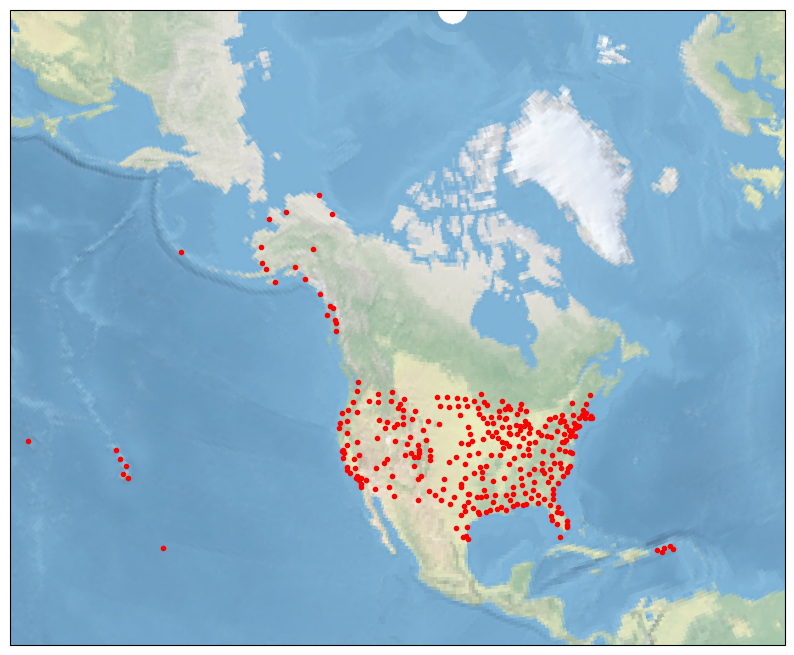

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100)})

# Ustalamy granice geograficzne dla Ameryki Północnej
ax.set_extent([-170, -50, 10, 90], ccrs.PlateCarree())

# Zmniejszamy rozmiar znacznika
marker_size = 3

# Dodajemy punkty na mapie
ax.plot(airports['LONGITUDE'], airports['LATITUDE'], 'ro', markersize=marker_size, transform=ccrs.PlateCarree())

# Dodajemy tło mapy
ax.stock_img()

# Wyświetlamy mapę
plt.show()

In [14]:
# function to calculate real distance between airports
def haversine(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c

    return distance


In [15]:
# Merge 'flights' with 'airports' for 'ORIGIN_AIRPORT'
df = pd.merge(flights, airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']], left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'ORIG_LATITUDE', 'LONGITUDE': 'ORIG_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)

# Merge 'flights' with 'airports' for 'DESTINATION_AIRPORT'
df = pd.merge(df, airports[['IATA_CODE', 'STATE','LATITUDE', 'LONGITUDE']], left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'DEST_LATITUDE', 'LONGITUDE': 'DEST_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)


In [16]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,1448,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,1448,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,1448,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,1448,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931


In [17]:
df['REAL_DISTANCE'] = df.apply(lambda row: haversine(row['ORIG_LATITUDE'], row['ORIG_LONGITUDE'], row['DEST_LATITUDE'], row['DEST_LONGITUDE']), axis=1)

In [18]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

Make target feature for classification model

In [19]:
df['ARRIVAL_DELAY_encoded'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

Change miles to kilometres


In [20]:
df['DISTANCE'] = df['DISTANCE'].apply(lambda dist: 1.609344*dist)

In [21]:
df['DISTANCE'].mean()

1324.3219861033567

In [22]:
df['REAL_DISTANCE'].mean()

1323.4628307063126

'REAL_DISTANCE' does not differ much from DISTANCE

In [25]:
df[df['ARRIVAL_DELAY']>30]['ARRIVAL_DELAY'].value_counts().sum()

600323

In [26]:
df['ARRIVAL_DELAY'].mean()

4.885903045804635

In [27]:
df['ARRIVAL_DELAY'].median()

-5.0

In [28]:
df['DEPARTURE_DELAY'].mean()

9.774567640166886

In [29]:
df['DEPARTURE_DELAY'].median()

-1.0

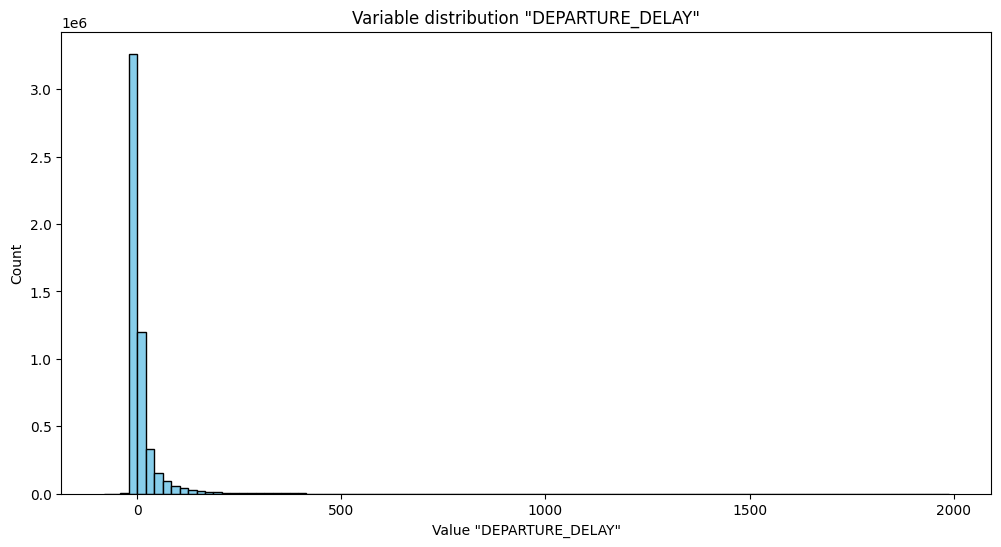

In [38]:
plt.figure(figsize=(12, 6))

plt.hist(df['DEPARTURE_DELAY'], bins=100, color='skyblue', edgecolor='black')
plt.title('Variable distribution "DEPARTURE_DELAY"')
plt.xlabel('Value "DEPARTURE_DELAY"')
plt.ylabel('Count')

plt.show()

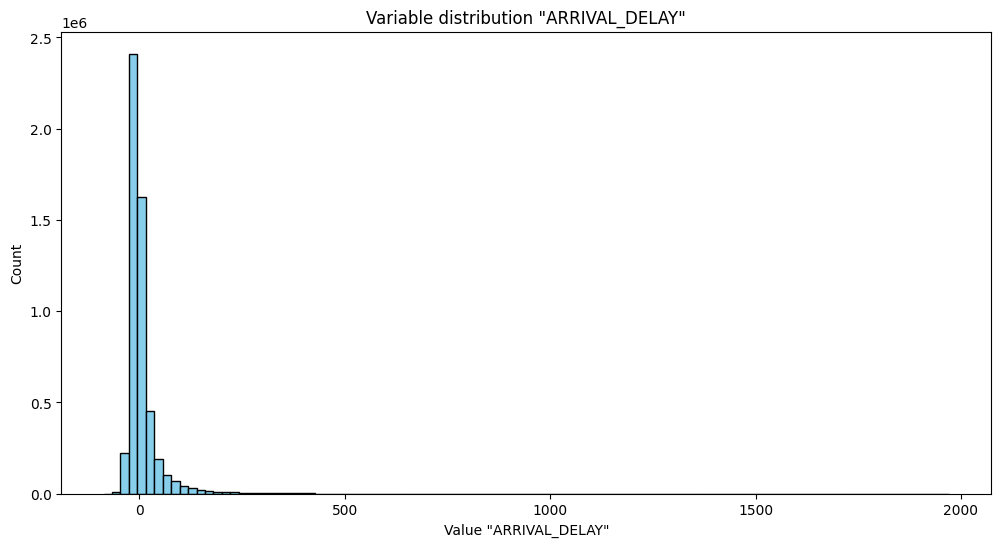

In [39]:
plt.figure(figsize=(12, 6))

plt.hist(df['ARRIVAL_DELAY'], bins=100, color='skyblue', edgecolor='black')
plt.title('Variable distribution "ARRIVAL_DELAY"')
plt.xlabel('Value "ARRIVAL_DELAY"')
plt.ylabel('Count')

plt.show()

In [40]:
df['CANCELLATION_REASON'][df['CANCELLATION_REASON'].notna()].value_counts()

B    47874
A    24309
C    15225
D       22
Name: CANCELLATION_REASON, dtype: int64

In [ ]:
df['AIR_SYSTEM_DELAY'][df['AIR_SYSTEM_DELAY']>0].value_counts().sum()

532628

In [ ]:
df['AIRLINE_DELAY'][df['AIRLINE_DELAY']>0].value_counts().sum()

538573

In [ ]:
df['WEATHER_DELAY'][df['WEATHER_DELAY']>0].value_counts().sum()

62610

In [ ]:
df['LATE_AIRCRAFT_DELAY'][df['LATE_AIRCRAFT_DELAY']>0].value_counts().sum()

529110

In [41]:
df['most_diverted_destinations'] = df.groupby('DESTINATION_AIRPORT')['DIVERTED'].transform('mean')

In [42]:
df['most_cancelled_origins'] = df.groupby('ORIGIN_AIRPORT')['CANCELLED'].transform('mean')

In [43]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [44]:
df['most_diverted_dates'] = df.groupby('DATE')['DIVERTED'].transform('mean')
df['most_cancelled_dates'] = df.groupby('DATE')['CANCELLED'].transform('mean')

In [45]:
df_cancelled = df[df['CANCELLED']==1]

In [46]:
df = df[df['CANCELLED']==0]
df = df.drop('CANCELLATION_REASON', axis=1)

In [47]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,ARRIVAL_DELAY_encoded,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,2330.330112,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,2330.330112,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,2330.330112,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,2330.330112,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,209.0,-11.0,15.0,224.0,200.0,199.0,176.0,2330.330112,620.0,8.0,640,628.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405


In [48]:
df_diverted = df[df['DIVERTED']!= 0]

In [49]:
df = df[df['DIVERTED']== 0]

In [50]:
df.isnull().sum()

YEAR                                0
MONTH                               0
DAY                                 0
DAY_OF_WEEK                         0
AIRLINE                             0
FLIGHT_NUMBER                       0
TAIL_NUMBER                         0
ORIGIN_AIRPORT                      0
DESTINATION_AIRPORT                 0
SCHEDULED_DEPARTURE                 0
DEPARTURE_TIME                      0
DEPARTURE_DELAY                     0
TAXI_OUT                            0
WHEELS_OFF                          0
SCHEDULED_TIME                      0
ELAPSED_TIME                        0
AIR_TIME                            0
DISTANCE                            0
WHEELS_ON                           0
TAXI_IN                             0
SCHEDULED_ARRIVAL                   0
ARRIVAL_TIME                        0
ARRIVAL_DELAY                       0
DIVERTED                            0
CANCELLED                           0
AIR_SYSTEM_DELAY              4227770
SECURITY_DEL

In [51]:
columns_to_fill = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

Columns with the time of individual flight stages in float form

In [53]:
for column in ['DEPARTURE_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_ON', 'WHEELS_OFF']:
  df[column] = df[column].astype(int).astype(str).apply(lambda x: ((4 - len(x))*'0')+str(x))
  df[column] = df[column].apply(lambda x: str(int(x[-2:])*(10/6)))
  df[column] = df[column].astype(float).astype(int)

In [54]:
df['SIN_DEPARTURE_TIME'] = np.sin(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['COS_DEPARTURE_TIME'] = np.cos(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['SIN_SCHEDULED_DEPARTURE'] = np.sin(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['COS_SCHEDULED_DEPARTURE'] = np.cos(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['SIN_SCHEDULED_ARRIVAL'] = np.sin(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['COS_SCHEDULED_ARRIVAL'] = np.cos(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['SIN_ARRIVAL_TIME'] = np.sin(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['COS_ARRIVAL_TIME'] = np.cos(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['SIN_WHEELS_ON'] = np.sin(2 * np.pi * df['WHEELS_ON'] / 2400)
df['COS_WHEELS_ON'] = np.cos(2 * np.pi * df['WHEELS_ON'] / 2400)
df['SIN_WHEELS_OFF'] = np.sin(2 * np.pi * df['WHEELS_OFF'] / 2400)
df['COS_WHEELS_OFF'] = np.cos(2 * np.pi * df['WHEELS_OFF'] / 2400)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5332913
Data columns (total 36 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             float64
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE                       0
FLIGHT_NUMBER                 0
TAIL_NUMBER                   0
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME                0
DEPARTURE_DELAY               0
TAXI_OUT                      0
WHEELS_OFF                    0
SCHEDULED_TIME                0
ELAPSED_TIME                  0
AIR_TIME                      0
DISTANCE                      0
WHEELS_ON                     0
TAXI_IN                       0
SCHEDULED_ARRIVAL             0
ARRIVAL_TIME                  0
ARRIVAL_DELAY                 0
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
ORIG_LATITUDE              4561
ORIG_LON

In [55]:
df['SIN_DAY_OF_WEEK'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['COS_DAY_OF_WEEK'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)

In [56]:
df = df.dropna()

In [57]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.groupby('AIRLINE')[['ARRIVAL_DELAY']].mean().sort_values(by='ARRIVAL_DELAY', ascending=False)

,ARRIVAL_DELAY
AIRLINE,
NK,15.225780
F9,13.758930
MQ,7.316540
EV,6.980759
B6,6.949339
OO,6.221438
UA,6.211316
VX,4.979539
WN,4.845657


In [60]:
airline_company_names = {
    'NK': 0,
    'F9': 1,
    'MQ': 2,
    'EV': 3,
    'B6': 4,
    'OO': 5,
    'UA': 6,
    'VX': 7,
    'WN': 8,
    'AA': 9,
    'US': 10,
    'HA': 11,
    'DL': 12,
    'AS': 13
}
df['AIRLINE_encoded'] = df['AIRLINE'].map(airline_company_names).astype(int)

In [61]:
df['SIZE_OF_DESTIN_AIRPORT'] = pd.qcut(df.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].transform('count'), q=10, labels=False)

In [62]:
df['SIZE_OF_ORIGIN_AIRPORT'] = pd.qcut(df.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].transform('count'), q=10, labels=False)

In [63]:
columns_to_encode = ['SECURITY_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
for column in  columns_to_encode:
  new_column_name = column + '_encoded'
  df[new_column_name] = df[column].apply(lambda col: 1 if col>0 else 0).astype(int)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [64]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [58]:
# Backup df_cancelled
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'

df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')

In [59]:
# Backup df_diverted
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'

df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [2]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,...,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5222000 entries, 0 to 5332913
Data columns (total 64 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   YEAR                         int64         
 1   MONTH                        int64         
 2   DAY                          int64         
 3   DAY_OF_WEEK                  int64         
 4   AIRLINE                      object        
 5   FLIGHT_NUMBER                int64         
 6   TAIL_NUMBER                  object        
 7   ORIGIN_AIRPORT               object        
 8   DESTINATION_AIRPORT          object        
 9   SCHEDULED_DEPARTURE          int64         
 10  DEPARTURE_TIME               int64         
 11  DEPARTURE_DELAY              float64       
 12  TAXI_OUT                     float64       
 13  WHEELS_OFF                   int64         
 14  SCHEDULED_TIME               float64       
 15  ELAPSED_TIME                 float64       
 16  

# First model

## Regression (with 'DEPARTURE_DELAY' feature) [link text](https://)



In [3]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'DEPARTURE_DELAY',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'SIZE_OF_ORIGIN_AIRPORT']

In [ ]:
len(selected_columns)

25

In [4]:
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEPARTURE_DELAY', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [6]:
model=Ridge(alpha=0.1)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [7]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [8]:
r2_lintrain = r2_score(y_train,y_pred_train)

mse_lin = mean_squared_error(y_test,y_pred)
print(f"R2_score (train): {r2_lintrain}")
print(f"Mean Squared Error: {mse_lin}")

R2_score (train): 0.9012258164188304
Mean Squared Error: 155.47301940579501


In [9]:
model.coef_

array([-1.50797152e-02, -1.95348566e+01,  1.58105498e+01,  2.83533655e-01,
        1.93110597e+00, -8.70002659e-02, -2.05376638e+00,  1.70784774e-03,
        3.72297295e+01, -7.71403322e+00, -5.49956324e+01, -5.84911639e-01,
       -4.34095293e+00,  3.18654946e-02, -5.90138665e-01,  6.02596760e-01,
        1.76648819e-01, -2.90374158e-01,  2.03040976e-01,  1.31081847e+01,
        3.70868545e+01,  1.96541167e+00,  3.13969485e+02,  1.55582314e+01,
       -4.83136192e-02])

## Classification (without 'DEPARTURE_DELAY' feature)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [11]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'SIZE_OF_ORIGIN_AIRPORT']

In [12]:
X = df[selected_columns]
y = df['ARRIVAL_DELAY_encoded']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [14]:
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
classification_rep = classification_report(y_test, y_pred)
print("Classification report:")
print(classification_rep)

Accuracy: 0.6288299502106472
Classification report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    655771
           1       0.58      0.01      0.02    388629

    accuracy                           0.63   1044400
   macro avg       0.61      0.50      0.39   1044400
weighted avg       0.61      0.63      0.49   1044400



# Feature engineering

In [ ]:
df['ARRIVAL_DELAY'].median()

-5.0

In [ ]:
df[df['DATE'] == '2015-12-23']['ARRIVAL_DELAY'].median()

5.0

In [ ]:
median_per_day = df.groupby(df['DATE'].dt.date)['ARRIVAL_DELAY'].median().sort_values()
median_per_day[median_per_day>0]

DATE
2015-12-26     1.0
2015-01-02     1.0
2015-06-15     1.0
2015-05-18     1.0
2015-04-10     1.0
2015-04-09     1.0
2015-03-05     1.0
2015-03-06     1.0
2015-02-17     2.0
2015-12-22     2.0
2015-07-18     2.0
2015-08-20     2.0
2015-02-16     3.0
2015-12-28     3.0
2015-06-18     3.0
2015-02-22     3.0
2015-03-02     4.0
2015-01-05     4.0
2015-03-03     4.0
2015-01-12     4.0
2015-01-06     4.0
2015-12-23     5.0
2015-02-26     5.0
2015-12-27     6.0
2015-12-29     6.0
2015-03-01     7.0
2015-12-30     9.0
2015-01-03    11.0
2015-01-04    14.0
Name: ARRIVAL_DELAY, dtype: float64

DATE

* 2015-12-26     1.0  holiday
* 2015-01-02     1.0  holiday
* 2015-06-15     1.0
* 2015-05-18     1.0
* 2015-04-10     1.0
* 2015-04-09     1.0
* 2015-03-05     1.0  extreme weather
* 2015-03-06     1.0  extreme weather
* 2015-02-17     2.0  extreme weather
* 2015-12-22     2.0  holiday
* 2015-07-18     2.0
* 2015-08-20     2.0  
* 2015-02-16     3.0  extreme weather
* 2015-12-28     3.0  holiday
* 2015-06-18     3.0  extreme weather
* 2015-02-22     3.0  holiday
* 2015-03-02     4.0  extreme weather
* 2015-01-05     4.0  holiday
* 2015-03-03     4.0  extreme weather
* 2015-01-12     4.0  holiday
* 2015-01-06     4.0  holiday
* 2015-12-23     5.0  holiday
* 2015-02-26     5.0  holiday
* 2015-12-27     6.0  holiday
* 2015-12-29     6.0  holiday
* 2015-03-01     7.0  extreme weather
* 2015-12-30     9.0  holiday
* 2015-01-03    11.0  holiday
* 2015-01-04    14.0  holiday

In [ ]:
df['DATE'].value_counts().sum()

5221218

In [ ]:
df['DATE'].value_counts()[:40].sum()

685056

In [ ]:
top_df_dates = median_per_day.index

DEPARTURE_DELAY and ARRIVAL_DELAY boxplots

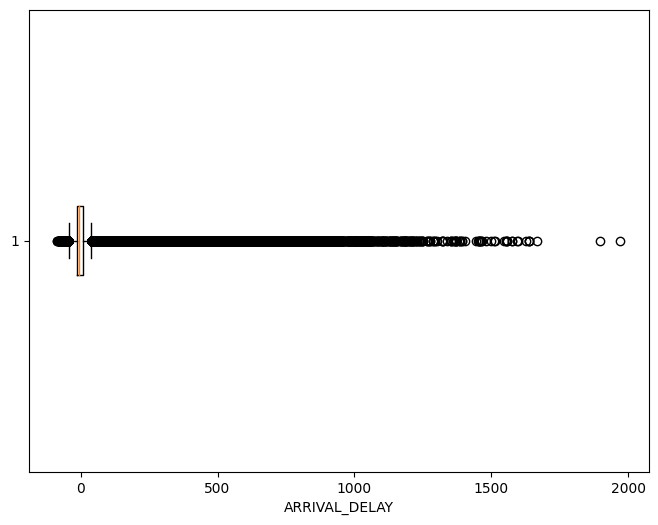

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['DEPARTURE_DELAY'], vert=False)

plt.xlabel('DEPARTURE_DELAY')

plt.show()

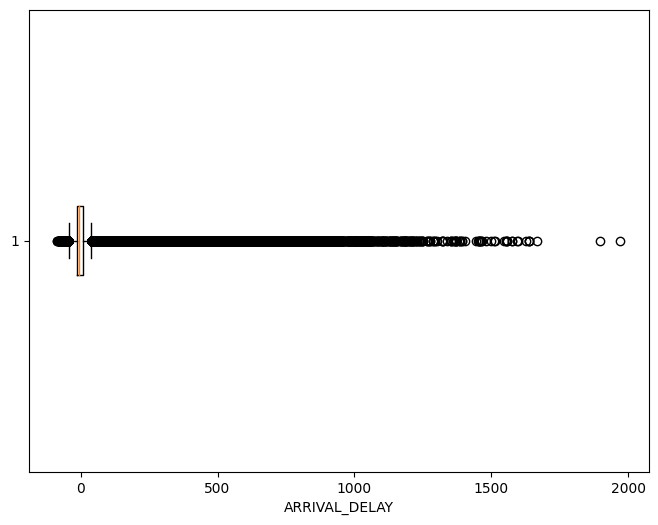

In [16]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['ARRIVAL_DELAY'], vert=False)

plt.xlabel('ARRIVAL_DELAY')

plt.show()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0


I check how many cases there were when the delay lasted more than 12 hours and remove these outliers

In [ ]:
df[df['ARRIVAL_DELAY']>730]['ARRIVAL_DELAY'].count()

779

In [17]:
df_delayed12h = df[df['ARRIVAL_DELAY']>=730]

In [18]:
df = df[df['ARRIVAL_DELAY']<730]

Logaritm of DEPARTURE_DELAY

In [33]:
df['log1p_departure_delay'] = np.log1p(df['DEPARTURE_DELAY'])

In [34]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')
# parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
# df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')
# parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
# df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

# Second model

## Regression (with 'DEPARTURE_DELAY' feature)



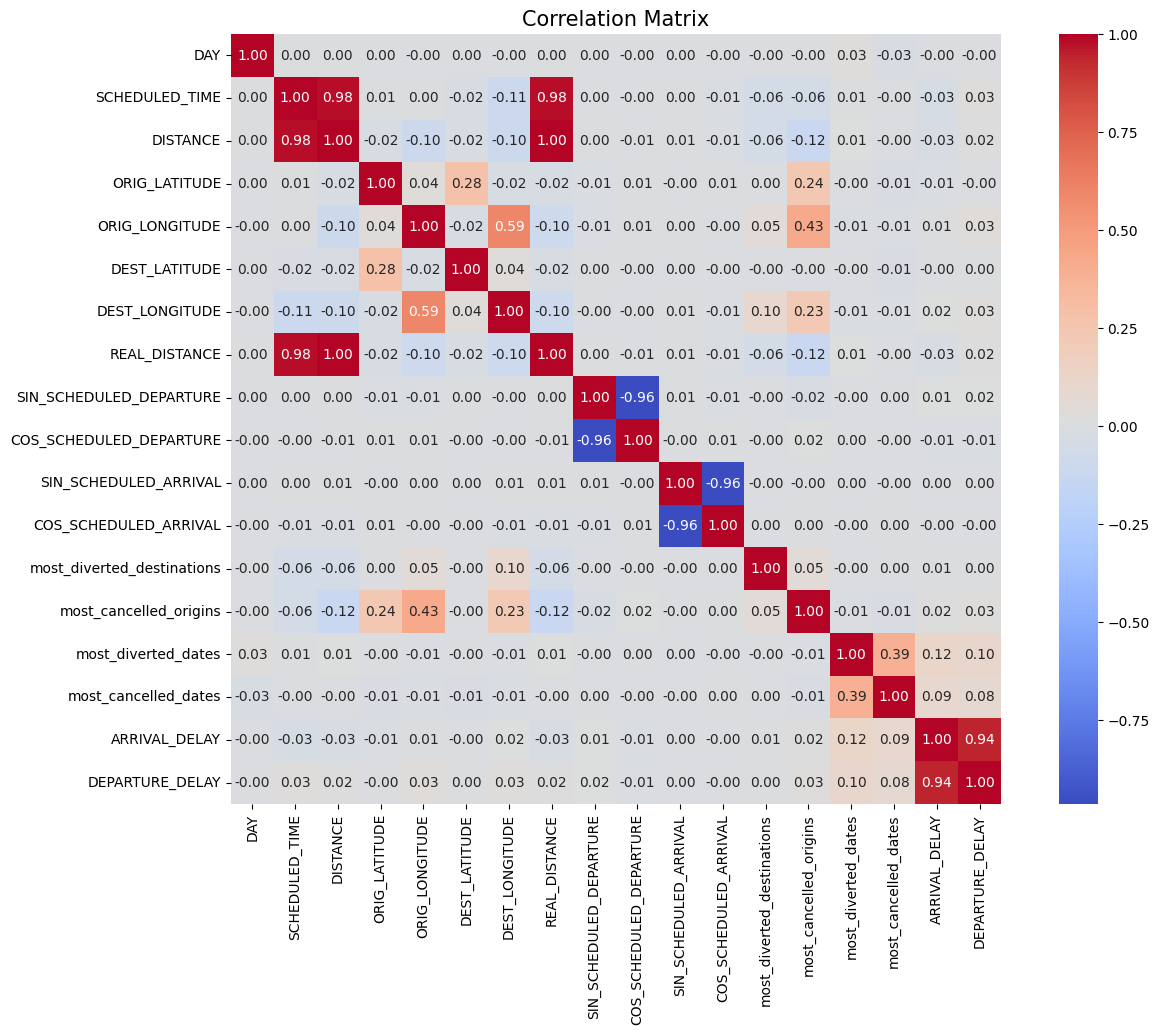

In [ ]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                  'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                  'ARRIVAL_DELAY',
                  'DEPARTURE_DELAY']

corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [ ]:
group_0_weather = df[df['WEATHER_DELAY_encoded'] == 0]['ARRIVAL_DELAY']
group_1_weather = df[df['WEATHER_DELAY_encoded'] == 1]['ARRIVAL_DELAY']

# Test t-STUDENT

t_statistic, p_value = ttest_ind(group_0_weather, group_1_weather)
print(f"Test t-studenta - weather:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")


Test t-studenta - weather:
t-statistic: -556.3914487897043
p-value: 0.0


Wartości t-statystyki są bardzo niskie, co wskazuje na duże różnice między grupami, a p-wartości są bliskie zeru (<0.05), co oznacza, że różnice te są istotne statystycznie.

In [ ]:
# Tworzenie grup na podstawie zmiennej kategorycznej
grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_ORIGIN_AIRPORT'] == i] for i in df['SIZE_OF_ORIGIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_ORIGIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_DESTIN_AIRPORT'] == i] for i in df['SIZE_OF_DESTIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_DESTIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['AIRLINE_encoded'] == i] for i in df['AIRLINE_encoded'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('AIRLINE_encoded:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")



SIZE_OF_ORIGIN_AIRPORT:
F-statistic: 700.9514243307518
P-value: 0.0
SIZE_OF_DESTIN_AIRPORT:
F-statistic: 378.8956244081768
P-value: 0.0
AIRLINE_encoded:
F-statistic: 2481.110964795245
P-value: 0.0


Wszystkie te wyniki sugerują, że te zmienne kategoryczne mają wpływ na zmienną numeryczną ARRIVAL_DELAY, a różnice między grupami tych zmiennych są istotne statystycznie. Innymi słowy, te zmienne kategoryczne mają wpływ na opóźnienia przyjazdu w analizowanych danych.

In [45]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'DEPARTURE_DELAY',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    ]

In [46]:
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE','DEPARTURE_DELAY', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [48]:
model=Ridge(alpha=0.1)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [49]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [50]:
mse = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

In [51]:
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")

R2_score (train): 0.8920663160746162
Mean Squared Error: 156.28305473824628


In [52]:
mae = mean_absolute_error(y_test, y_pred)

In [53]:
mae

8.74959667756083

MSE higher than before

## Classification (without 'DEPARTURE_DELAY' feature)

In [55]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    ]

In [56]:
X = df[selected_columns]
y = df['ARRIVAL_DELAY_encoded']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [58]:
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [59]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
classification_rep = classification_report(y_test, y_pred)
print("Classification report:")
print(classification_rep)

Accuracy: 0.641481301305059
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.77    655853
           1       0.69      0.07      0.12    388391

    accuracy                           0.64   1044244
   macro avg       0.66      0.52      0.45   1044244
weighted avg       0.66      0.64      0.53   1044244



# Feature Enginnering

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [ ]:
df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index

Index(['GST', 'ADK', 'PPG', 'ILG', 'AKN', 'OME', 'STC', 'RHI', 'ITH', 'COD',
       ...
       'DLG', 'LSE', 'TOL', 'VEL', 'DIK', 'LAR', 'PSE', 'BTM', 'HYA', 'CNY'],
      dtype='object', name='ORIGIN_AIRPORT', length=319)

In [60]:
origin_airports_to_encode = list(df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [61]:
origin_airports_mapping = {}

for i, airport in enumerate(origin_airports_to_encode):
    origin_airports_mapping[airport] = i

In [62]:
df['ORIGIN_AIRPORT_RANK'] = df['ORIGIN_AIRPORT'].map(origin_airports_mapping).astype(int)

In [63]:
destin_airports_to_encode = list(df.groupby(df['DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [64]:
destin_airports_mapping = {}


for i, airport in enumerate(destin_airports_to_encode):
    destin_airports_mapping[airport] = i

In [65]:
df['DESTIN_AIRPORT_RANK'] = df['DESTINATION_AIRPORT'].map(destin_airports_mapping).astype(int)

In [ ]:
df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values()

AIRLINE
HA     262.323072
MQ     585.801216
EV     690.408576
OO     704.892672
WN    1010.668032
DL    1039.636224
US    1047.682944
F9    1440.362880
AS    1535.314176
NK    1540.142208
AA    1577.157120
B6    1627.046784
UA    1713.951360
VX    2222.504064
Name: DISTANCE, dtype: float64

In [66]:
airlines_to_encode_by_distance = list(df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values().index)

In [67]:
airlines_by_distance_mapping = {}

for i, airline in enumerate(airlines_to_encode_by_distance):
    airlines_by_distance_mapping[airline] = i

In [68]:
df['AIRLINES_BY_DISTANCE'] = df['AIRLINE'].map(airlines_by_distance_mapping).astype(int)

In [69]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,ARRIVAL_DELAY_encoded,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,log1p_arrival_delay,log1p_departure_delay,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,NaN,NaN,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,NaN,NaN,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0,NaN,NaN,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,NaN,NaN,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,NaN,NaN,137,195,8


In [70]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [6]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

# Third model

## Regression (with 'DEPARTURE_DELAY' feature)

In [37]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'DEPARTURE_DELAY',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',]

In [38]:
df_selected = df[selected_columns]
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_selected.parquet'
df_selected.to_parquet(parquet_file_path, engine='pyarrow')
df_target = df[['ARRIVAL_DELAY']]
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_target.parquet'
df_target.to_parquet(parquet_file_path, engine='pyarrow')

In [5]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_selected.parquet'
table = pq.read_table(parquet_file_path)
df_selected = table.to_pandas()
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_target.parquet'
table = pq.read_table(parquet_file_path)
df_target = table.to_pandas()

In [6]:
X = df_selected
y = df_target['ARRIVAL_DELAY']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE','DEPARTURE_DELAY', 'DEST_LONGITUDE'
                    ,'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',]
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [42]:
model_Ridge=Ridge(alpha=0.5)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [43]:
y_pred = model_Ridge.predict(X_test)
y_pred_train = model_Ridge.predict(X_train)

In [44]:
mse = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")

R2_score (train): 0.8923612216998862
Mean Squared Error: 155.8718184103901


XGBoost

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from xgboost import XGBRegressor

model_XG = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


model_XG.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [7]:
y_pred = model_XG.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
print(f"XGBoost mse: {mse}")

XGBoost mse: 154.3069469350176


In [9]:
import joblib

joblib.dump(model_XG, '/content/drive/MyDrive/Kurs/final_project/models/xgboost.pkl')

['/content/drive/MyDrive/Kurs/final_project/models/xgboost.pkl']

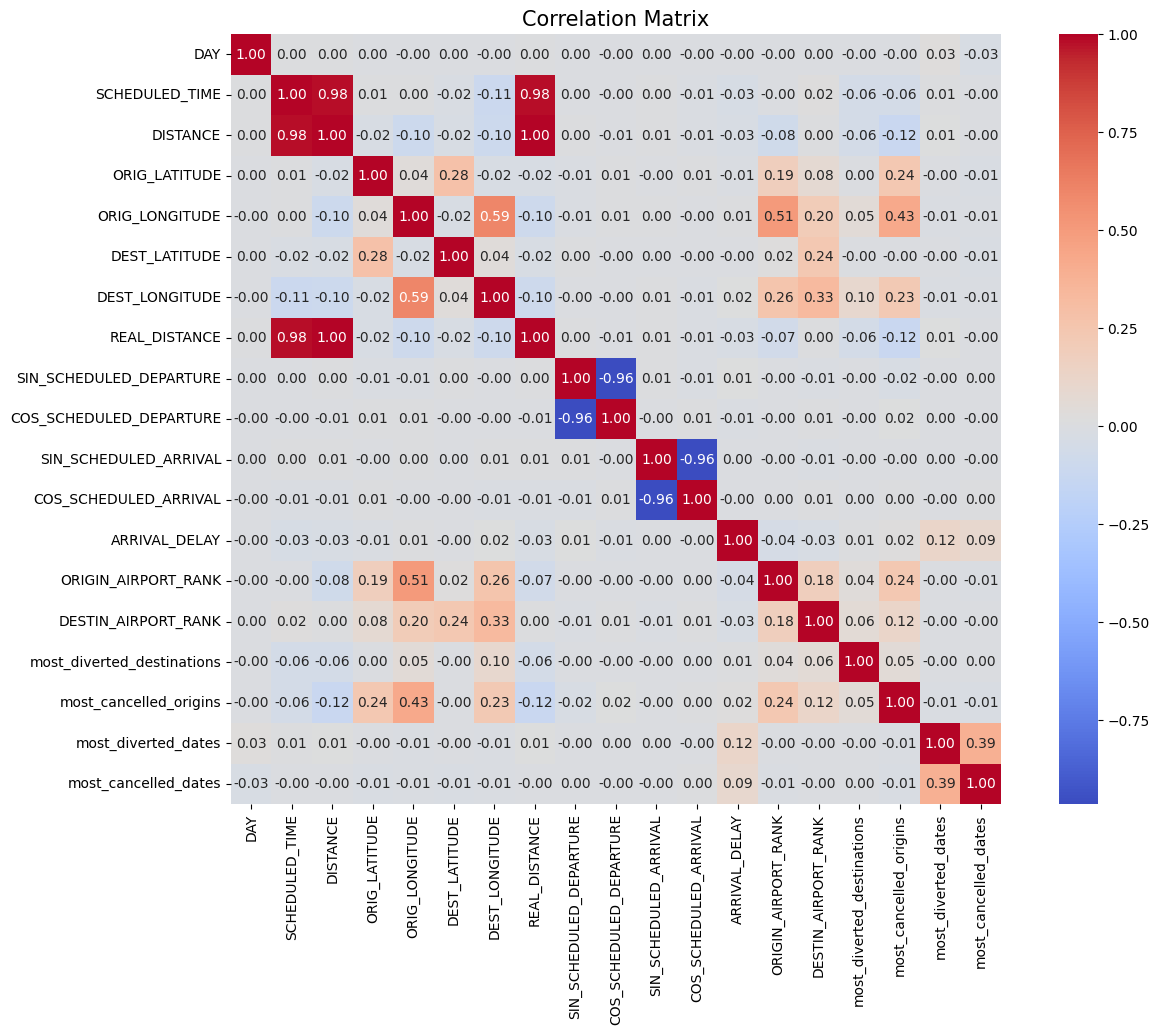

In [16]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'ARRIVAL_DELAY',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                  'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',]
corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

## Classification (without 'DEPARTURE_DELAY' feature)

In [26]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    ]

In [28]:
df_selected_classification = df[selected_columns]
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_selected_classification.parquet'
df_selected_classification.to_parquet(parquet_file_path, engine='pyarrow')
df_target_encoded = df[['ARRIVAL_DELAY_encoded']]
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_target_encoded.parquet'
df_target_encoded.to_parquet(parquet_file_path, engine='pyarrow')

In [10]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_selected_classification.parquet'
table = pq.read_table(parquet_file_path)
df_selected_classification = table.to_pandas()
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_target_encoded.parquet'
table = pq.read_table(parquet_file_path)
df_target_encoded = table.to_pandas()

In [11]:
X = df_selected_classification
y = df_target_encoded['ARRIVAL_DELAY_encoded']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LONGITUDE'
                    ,'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',]
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [13]:
model = LogisticRegression(penalty='l2', C=1.0)

In [14]:
model.fit(X_train, y_train)

LogisticRegression()

In [16]:
joblib.dump(model, '/content/drive/MyDrive/Kurs/final_project/models/logistic.pkl')

['/content/drive/MyDrive/Kurs/final_project/models/logistic.pkl']

In [35]:
y_pred = model.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
classification_rep = classification_report(y_test, y_pred)
print("Classification report:")
print(classification_rep)

Accuracy: 0.6277613278122738
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.99      0.77    655853
           1       0.49      0.02      0.04    388391

    accuracy                           0.63   1044244
   macro avg       0.56      0.50      0.40   1044244
weighted avg       0.58      0.63      0.50   1044244



Random forest

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [16]:
y_pred = model_rf.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy- random forest: {accuracy}")

classification_rep = classification_report(y_test, y_pred)
print("classification report:")
print(classification_rep)

Accuracy- random forest: 0.6399768636448953
classification report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78    655853
           1       1.00      0.03      0.06    388391

    accuracy                           0.64   1044244
   macro avg       0.82      0.52      0.42   1044244
weighted avg       0.77      0.64      0.51   1044244



In [18]:

parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/X_test_classification.parquet'
X_test.to_parquet(parquet_file_path, engine='pyarrow')

parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/y_test_encoded.parquet'
y_test.to_parquet(parquet_file_path, engine='pyarrow')

AttributeError: ignored

## Dump models to pickles

In [2]:
!pip install joblib

In [ ]:
import joblib

joblib.dump(model_XG, '/content/drive/MyDrive/Kurs/final_project/models/xgboost.pkl')
joblib.dump(model_lr, '/content/drive/MyDrive/Kurs/final_project/models/logistic.pkl')

# Feature Engineering

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8


In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/weather.csv')

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2736 non-null   object 
 1   datetime       2736 non-null   object 
 2   tempmin        2736 non-null   float64
 3   temp           2736 non-null   float64
 4   dew            2736 non-null   float64
 5   humidity       2736 non-null   float64
 6   precip         2736 non-null   float64
 7   precipprob     2736 non-null   int64  
 8   snow           2546 non-null   float64
 9   snowdepth      2546 non-null   float64
 10  windspeedmax   2736 non-null   float64
 11  windspeedmean  2736 non-null   float64
 12  cloudcover     2736 non-null   float64
 13  visibility     2736 non-null   float64
 14  Abbreviation   2736 non-null   object 
dtypes: float64(11), int64(1), object(3)
memory usage: 320.8+ KB


In [ ]:
weather = weather.drop('name', axis=1)
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [ ]:
df = df.merge(weather, left_on=['STATE', 'DATE'], right_on=['Abbreviation', 'datetime'], how='inner')

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE,datetime,tempmin,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeedmax,windspeedmean,cloudcover,visibility,Abbreviation
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0,137,195,5,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA


In [ ]:
df = df.drop('Abbreviation', axis=1)

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-03-17')

In [ ]:
df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [ ]:
df.isna().sum()

YEAR                  0
MONTH                 0
DAY                   0
DAY_OF_WEEK           0
AIRLINE               0
                  ...  
snowdepth        121243
windspeedmax          0
windspeedmean         0
cloudcover            0
visibility            0
Length: 81, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820023 entries, 0 to 820022
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   YEAR                         820023 non-null  int64         
 1   MONTH                        820023 non-null  int64         
 2   DAY                          820023 non-null  int64         
 3   DAY_OF_WEEK                  820023 non-null  int64         
 4   AIRLINE                      820023 non-null  object        
 5   FLIGHT_NUMBER                820023 non-null  int64         
 6   TAIL_NUMBER                  820023 non-null  object        
 7   ORIGIN_AIRPORT               820023 non-null  object        
 8   DESTINATION_AIRPORT          820023 non-null  object        
 9   SCHEDULED_DEPARTURE          820023 non-null  int64         
 10  DEPARTURE_TIME               820023 non-null  int64         
 11  DEPARTURE_DELAY           

In [ ]:
df[df['snowdepth'].isna()].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE,datetime,tempmin,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeedmax,windspeedmean,cloudcover,visibility
26097,2015,1,1,4,US,617,N804AW,ANC,PHX,86,71,-9.0,21.0,6,323.0,322.0,298.0,4107.045888,3,3.0,25,8,-10.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,AZ,33.43417,-112.00806,4101.625919,0.001526,0.007748,2015-01-01,0.001434,0.033405,0.184809,0.982774,0.223250,0.974761,0.065403,0.997859,0.020942,0.999781,0.007854,0.999969,0.015707,0.999877,-0.433884,-0.900969,0.5,0.866025,10,7,1,0,0,0,0,0,137,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26098,2015,1,1,4,AS,172,N577AS,ANC,PHX,75,63,-7.0,19.0,95,345.0,323.0,298.0,4107.045888,91,6.0,50,1,-29.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,AZ,33.43417,-112.00806,4101.625919,0.001526,0.007748,2015-01-01,0.001434,0.033405,0.164187,0.986429,0.195090,0.980785,0.130526,0.991445,0.002618,0.999997,0.235990,0.971755,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,7,1,0,0,0,0,0,137,141,8,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26099,2015,1,1,4,US,649,N912UY,LAX,PHX,50,41,-5.0,17.0,70,79.0,88.0,53.0,595.457280,58,18.0,81,88,4.0,0,0,0.0,0.0,0.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.107132,0.994245,0.130526,0.991445,0.210472,0.977600,0.228351,0.973579,0.151261,0.988494,0.182236,0.983255,-0.433884,-0.900969,0.5,0.866025,10,7,7,0,0,0,0,0,44,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26100,2015,1,1,4,US,582,N823AW,LAX,PHX,66,53,-8.0,12.0,73,94.0,82.0,60.0,595.457280,73,10.0,23,90,-20.0,0,0,0.0,0.0,0.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.138309,0.990389,0.171929,0.985109,0.060177,0.998188,0.233445,0.972370,0.189952,0.981793,0.189952,0.981793,-0.433884,-0.900969,0.5,0.866025,10,7,7,0,0,0,0,0,44,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26101,2015,1,1,4,WN,3492,N732SW,LAX,PHX,91,86,297.0,8.0,0,75.0,70.0,57.0,595.457280,95,5.0,16,3,292.0,0,0,0.0,0.0,292.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.223250,0.974761,0.235990,0.971755,0.041876,0.999123,0.007854,0.999969,0.246153,0.969231,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,8,7,7,0,0,1,0,0,44,141,4,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0


In [ ]:
df = df.fillna(0)

0.0     461421
0.1      10050
0.2       7084
4.6       5901
2.2       5406
         ...  
41.2         5
23.6         5
49.5         5
45.3         4
43.3         2
Name: snowdepth, Length: 279, dtype: int64

In [ ]:
df = df.fillna(0)

# 4th model - much smaller model - not enough weather data

In [ ]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'tempmin',
                    'temp',
                    'dew',
                    'humidity',
                    'precip',
                    'precipprob',
                    'snow',
                    'snowdepth',
                    'windspeedmax',
                    'windspeedmean',
                    'cloudcover',
                    'visibility'
                    ]

In [ ]:
df_sampled = df.sample(500000).copy()
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'ORIGIN_AIRPORT_RANK', 'DESTIN_AIRPORT_RANK']
# scaler = StandardScaler()
# X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
# X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [ ]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 8, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 20)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-26 18:09:36,095] A new study created in memory with name: no-name-5f105e60-7736-4362-8b01-9db8cf1fa2ee
[I 2023-09-26 18:09:46,062] Trial 0 finished with value: 1375.92191652622 and parameters: {'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 12}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:09:58,198] Trial 1 finished with value: 1393.2192814584826 and parameters: {'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:06,292] Trial 2 finished with value: 1397.0006452334544 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:15,640] Trial 3 finished with value: 1379.718420309753 and parameters: {'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 17}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:27,813] Trial 4 finished with value: 1381.12678

KeyboardInterrupt: ignored